In [150]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from languages import LANGUAGES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
loaded_df = pd.read_csv("Japanese_English_Processed.csv")

## Phonetic Inventory

In [152]:
print(len(loaded_df))

176910


In [153]:
# Extract the list of pronunciations
pronunciation_list = []
for p in loaded_df['pronunciation']:
    pronunciation_list.append(str(p))

In [154]:
print(len(pronunciation_list))

176910


In [155]:
# Print a histogram of the different symbols
symbols_hist = {}

for P in pronunciation_list:
    # Make use of only the narrow transcriptions.
    for x in P:
        if x in symbols_hist.keys():
            symbols_hist[x] += 1
        else:
            symbols_hist[x] = 1  

# Sort the symbols 
symbols = sorted(symbols_hist, key = lambda x: symbols_hist[x], reverse = True)

In [156]:
total = np.sum(list(symbols_hist.values()))
rare_symbols = []
final_symbols = []
uni_percent = 1/len(symbols_hist)
for x in symbols:
    percent = symbols_hist[x] / total * 100
    zipf_factor = percent / (symbols_hist[symbols[0]] / total * 100)  
    if (zipf_factor < uni_percent):
        rare_symbols.append(x)
    else:
        final_symbols.append(x)
        
print(rare_symbols) 
symbols = final_symbols

['ʉ', 'ɐ', 'ʔ', 'ɘ', 'x', 'ʍ', '‿', '˦', '˨', 'ʷ', '̈', '̪', 'ä', 'y', '˧', 'ɵ', 'ʁ', '̆', 'ɬ', '˩', 'ˑ', 'ɱ', '~', '˞', '˥', 'ꜜ', 'ø', '/', 'ũ', 'ʈ', 'ɻ', '˔', 'N', '̬', '̝', 'ɖ', 'œ', 'ˀ', 'ʱ', 'c', '*', 'ʏ', 'ᵊ', 'ʋ', 'χ', '‖', 'ɦ', '²', '→', 'ⁿ', 'ˤ', '̰', 'ɣ', 'í', 'ó', 'á', 'ʼ', '|', 'å', 'β', 'ǀ', 'Q', 'ɽ', 'ᵑ', 'ˠ', '⁵', '…', '̍', 'ɳ', 'ŏ', 'q', 'à', 'ò', 'ñ', 'ɞ', 'ɤ', 'ɟ', 'ᵈ', '>', '¹', 'C', 'ʂ', '͍', 'ǃ', '͜', 'ʙ', 'ħ', 'ă', 'ɭ', '̀', 'ʀ', '˗', 'ì', 'ʎ', '↓', '̙', 'ï', '᷈', 'ā', 'ʟ', "'", 'ö', 'ʘ', 'ˡ', 'ᵻ', 'ǁ', 'ĭ', 'ŭ', 'ɥ', '꜔', '\u200b', 'ḁ', '%', '˕', 'ɓ', '̜', '͇', 'ü', 'ʝ', '³', '⁰', 'ʐ', 'ḿ', '↗', '︎', 'ʬ', '́', '̘', 'ō', '⁴', '̽', 'ʩ', '𐞪']


In [157]:
# Remove entries with rare symbols from the dataset
final_list = []
for p in pronunciation_list:
    x : str = p
    banned = False
    for rare in rare_symbols:
        if x.find(rare) >= 0: 
            banned = True 
            break 

    if not banned:
        final_list.append(x)

In [158]:
pronunciation_list = final_list
print(len(pronunciation_list))

174040


In [159]:
for s in symbols:
    if s == "/" or s == "[" or s == "]":
        continue 
    print(s)

ˈ
ə
ɪ
t
k
i
s
n
ː
a
̞
.
ɹ
d
l
o
̠
m
ᵝ
e
p
b
ʊ
ˌ
̟
ɛ
æ
ɯ
͡
ɡ
z
ɾ
ʲ
ɑ
 
f
ʃ
ɕ
j
u
ɨ
ɔ
h
ɒ
(
)
v
ŋ
ʌ
ʒ
w
ɴ
ɚ
ã
ʑ
ẽ
ɰ
̃
θ
ĩ
-
ɜ
̚
̩
ɲ
r
ɸ
õ
ɝ
̥
ç
ð
̯
̊
ɫ
ʰ


In [160]:
print(len(symbols))

76


# Tokenizer

In [161]:
from tokenizers import Tokenizer, models, processors, decoders
import pandas as pd 
import numpy as np
from languages import LANGUAGES

In [162]:
loaded_df = pd.read_csv("English_Processed.csv")
loaded_df.head()

,Unnamed: 0,pronunciation,word,language
0,0,pəˈsɛnt,%,English
1,1,pɚˈsɛnt,%,English
2,2,kʊŋ,!kung,English
3,3,ǃkʊŋ,!kung,English
4,4,ænd lɪt,&lit,English


In [163]:
from solution import CharacterTokenizer, PhoneticTransformer, generate_square_subsequent_mask, PhoneticsDataset
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [164]:
from tokenizers import Tokenizer, AddedToken
from tokenizers.trainers import WordPieceTrainer


In [165]:
# pronunciation_tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
# pronunciation_tokenizer.train_from_iterator(pronunciation_list, WordPieceTrainer(vocab_size=200))
# pronunciation_tokenizer.add_special_tokens([
#     "[BOS]", "[EOS]", "[SEP]", "[PAD]", "[MASK]", "[UNK]", "[CLS]"
#     ])
# pronunciation_tokenizer.post_processor = processors.TemplateProcessing(
#     single = f"[BOS]:0 $A:0 [EOS]:0",
#     pair = f"[BOS]:0 $A:0 [SEP]:0 $B:1 [EOS]:1",
#     special_tokens=[("[BOS]", pronunciation_tokenizer.get_vocab()["[BOS]"]),
#                     ("[EOS]", pronunciation_tokenizer.get_vocab()["[EOS]"])
#     ]
# )
# pronunciation_tokenizer.decoder = decoders.WordPiece()
# vocab = pronunciation_tokenizer.get_vocab()
# print(len(vocab))

In [166]:
pronunciation_tokenizer = CharacterTokenizer(symbols, 100)
vocab = pronunciation_tokenizer.get_vocab()

c:\Users\Joaquin\miniconda3\envs\agi\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [167]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, len(vocab))

cuda 83


In [168]:
dataset = []
for p in pronunciation_list:
    tok = pronunciation_tokenizer.encode(p)
    row = []
    for t in tok.ids: 
        row.append(t)
        # dataset.append(row.copy())      
    dataset.append(row)

11.861135371179039 22.0 4.514784518018889
3 78


(array([5.9400e+02, 9.6000e+02, 4.6960e+03, 7.8730e+03, 8.3830e+03,
        1.3387e+04, 1.8681e+04, 2.0337e+04, 1.7897e+04, 1.6410e+04,
        1.4449e+04, 1.2159e+04, 8.9470e+03, 7.1410e+03, 5.3620e+03,
        4.1380e+03, 2.9800e+03, 2.3030e+03, 1.6870e+03, 1.3080e+03,
        9.8600e+02, 6.9400e+02, 6.4000e+02, 4.2000e+02, 3.5000e+02,
        2.2000e+02, 1.8400e+02, 1.5700e+02, 1.1300e+02, 8.3000e+01,
        7.8000e+01, 7.2000e+01, 5.8000e+01, 3.8000e+01, 4.6000e+01,
        2.6000e+01, 2.3000e+01, 1.7000e+01, 1.5000e+01, 1.4000e+01,
        1.2000e+01, 1.0000e+01, 8.0000e+00, 8.0000e+00, 2.0000e+00,
        6.0000e+00, 1.1000e+01, 5.0000e+00, 8.0000e+00, 5.0000e+00,
        7.0000e+00, 4.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.00

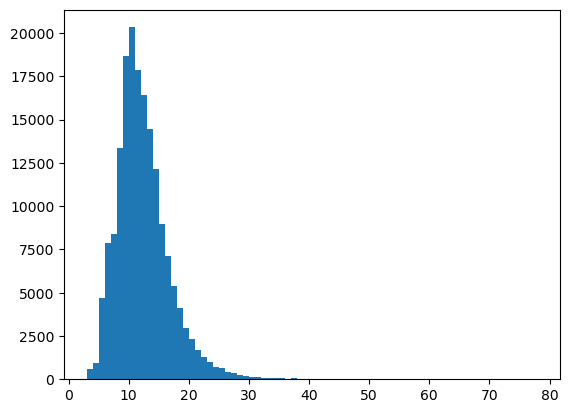

In [169]:
lengths = []
for i in dataset: 
    lengths.append(len(i))

print(np.mean(lengths), np.quantile(lengths, 0.975), np.std(lengths))
print(np.min(lengths), np.max(lengths))
plt.hist(lengths, np.max(lengths) - np.min(lengths))

In [170]:
# Remove any outliers
min_thresh = 3
max_thresh = np.quantile(lengths, 0.975)

work_set = []

for p in dataset:
    if len(p) >= min_thresh and len(p) <= max_thresh:
        work_set.append(p)

dataset = work_set

print(len(dataset))

169692


11.470475921080546 20.0 3.735903570375582
3 22


(array([  594.,   960.,  4696.,  7873.,  8383., 13387., 18681., 20337.,
        17897., 16410., 14449., 12159.,  8947.,  7141.,  5362.,  4138.,
         2980.,  2303.,  2995.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22.]),
 <BarContainer object of 19 artists>)

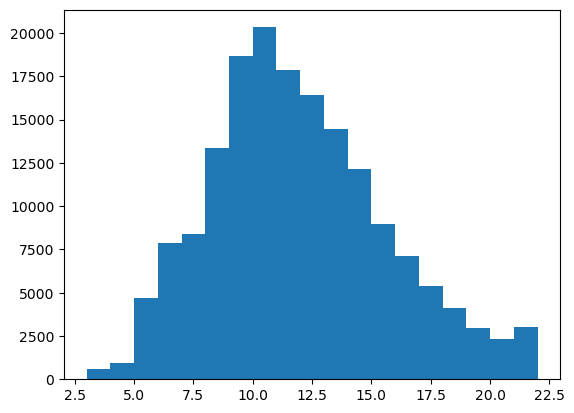

In [171]:
lengths = []
for i in dataset: 
    lengths.append(len(i))

print(np.mean(lengths), np.quantile(lengths, 0.975), np.std(lengths))
print(np.min(lengths), np.max(lengths))
plt.hist(lengths, np.max(lengths) - np.min(lengths))

In [172]:
SEQ_LEN = int(np.max(lengths))
BATCH_SIZE = 1024

<BarContainer object of 76 artists>

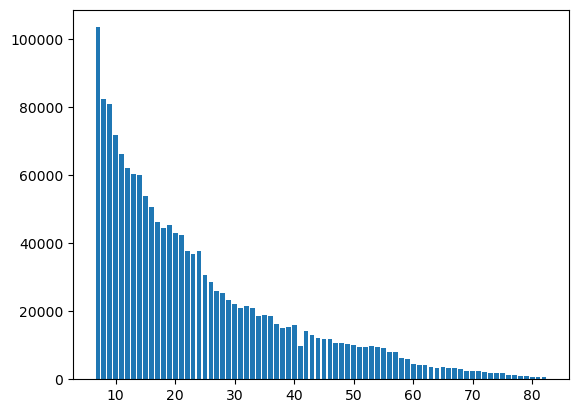

In [173]:
symbols_hist = {}
for d in dataset:
    for x in d[1:-1]:
        if x in symbols_hist.keys():
            symbols_hist[x] += 1
        else:
            symbols_hist[x] = 1  
sorted_hist =dict(sorted(symbols_hist.items(), key=lambda item: item[1], reverse=True)) 
plt.bar(sorted_hist.keys(), sorted_hist.values())

In [174]:
phonetics_dataset = PhoneticsDataset(dataset, vocab, SEQ_LEN)
dataloader = DataLoader(phonetics_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(dataloader))

166


In [175]:
from transformers import GPT2LMHeadModel, GPT2Model, GPT2Config
phonetics_model = GPT2LMHeadModel(GPT2Config(
    vocab_size=len(vocab) + 1,
    n_positions=SEQ_LEN,
    n_embd=72,
    n_layer = 4, 
    n_head = 4, 
    bos_token_id=vocab["[BOS]"],
    eos_token_id=vocab["[EOS]"],
    
))
phonetics_model = phonetics_model.to(device)

In [176]:
optimizer = optim.Adam(phonetics_model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.get("[PAD]"))
EPOCHS = 100

for epoch in range(EPOCHS):
    phonetics_model.train()
    total_loss = 0

    for i, (input_ids, target_ids) in tqdm(enumerate(dataloader), total=len(dataloader)):
        input_ids = input_ids.to(device)
        target_ids = target_ids.to(device)
        optimizer.zero_grad()
        tgt_mask = generate_square_subsequent_mask(input_ids.size(1)).to(device)
        output = phonetics_model(input_ids).logits
        loss = criterion(output.permute(0, 2, 1), target_ids)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    if ((epoch + 1) % 10 == 0):
        torch.save(phonetics_model.state_dict(), f"model{(epoch//10)}")
        
    print(f"Epoch {epoch + 1} Train Loss: {total_loss / len(dataloader)}")

100%|██████████| 166/166 [00:18<00:00,  9.18it/s]


Epoch 1 Train Loss: 3.7692243449659233


100%|██████████| 166/166 [00:17<00:00,  9.52it/s]


Epoch 2 Train Loss: 3.1171088563390525


100%|██████████| 166/166 [00:17<00:00,  9.53it/s]


Epoch 3 Train Loss: 2.7576198247541863


100%|██████████| 166/166 [00:17<00:00,  9.51it/s]


Epoch 4 Train Loss: 2.5598030521208983


100%|██████████| 166/166 [00:17<00:00,  9.52it/s]


Epoch 5 Train Loss: 2.4431170799646034


100%|██████████| 166/166 [00:17<00:00,  9.54it/s]


Epoch 6 Train Loss: 2.3695358138486564


100%|██████████| 166/166 [00:17<00:00,  9.54it/s]


Epoch 7 Train Loss: 2.318234572927636


100%|██████████| 166/166 [00:17<00:00,  9.42it/s]


Epoch 8 Train Loss: 2.281300620860364


100%|██████████| 166/166 [00:17<00:00,  9.52it/s]


Epoch 9 Train Loss: 2.2521871759230834


100%|██████████| 166/166 [00:17<00:00,  9.52it/s]


Epoch 10 Train Loss: 2.2292617875409415


100%|██████████| 166/166 [00:17<00:00,  9.52it/s]


Epoch 11 Train Loss: 2.210006557315229


100%|██████████| 166/166 [00:17<00:00,  9.55it/s]


Epoch 12 Train Loss: 2.194151756275131


100%|██████████| 166/166 [00:17<00:00,  9.65it/s]


Epoch 13 Train Loss: 2.1798932207636086


100%|██████████| 166/166 [00:17<00:00,  9.48it/s]


Epoch 14 Train Loss: 2.1675442600824746


100%|██████████| 166/166 [00:17<00:00,  9.54it/s]


Epoch 15 Train Loss: 2.1571970991341463


100%|██████████| 166/166 [00:17<00:00,  9.51it/s]


Epoch 16 Train Loss: 2.147378950233919


100%|██████████| 166/166 [00:17<00:00,  9.39it/s]


Epoch 17 Train Loss: 2.138926556311458


100%|██████████| 166/166 [00:17<00:00,  9.47it/s]


Epoch 18 Train Loss: 2.130291763558445


100%|██████████| 166/166 [00:17<00:00,  9.48it/s]


Epoch 19 Train Loss: 2.123751519674278


100%|██████████| 166/166 [00:17<00:00,  9.49it/s]


Epoch 20 Train Loss: 2.116269375904497


100%|██████████| 166/166 [00:17<00:00,  9.51it/s]


Epoch 21 Train Loss: 2.1105100878749985


100%|██████████| 166/166 [00:17<00:00,  9.35it/s]


Epoch 22 Train Loss: 2.104854694331985


100%|██████████| 166/166 [00:17<00:00,  9.49it/s]


Epoch 23 Train Loss: 2.0992646806211357


100%|██████████| 166/166 [00:17<00:00,  9.54it/s]


Epoch 24 Train Loss: 2.0941922377391036


100%|██████████| 166/166 [00:17<00:00,  9.47it/s]


Epoch 25 Train Loss: 2.0895616304443543


100%|██████████| 166/166 [00:17<00:00,  9.48it/s]


Epoch 26 Train Loss: 2.0852444775133248


100%|██████████| 166/166 [00:17<00:00,  9.47it/s]


Epoch 27 Train Loss: 2.0814503876559707


100%|██████████| 166/166 [00:17<00:00,  9.49it/s]


Epoch 28 Train Loss: 2.0767098392348693


100%|██████████| 166/166 [00:17<00:00,  9.42it/s]


Epoch 29 Train Loss: 2.07344602389508


100%|██████████| 166/166 [00:17<00:00,  9.42it/s]


Epoch 30 Train Loss: 2.0699860087360245


100%|██████████| 166/166 [00:17<00:00,  9.42it/s]


Epoch 31 Train Loss: 2.0666429378900184


100%|██████████| 166/166 [00:17<00:00,  9.44it/s]


Epoch 32 Train Loss: 2.0637155584542146


100%|██████████| 166/166 [00:17<00:00,  9.42it/s]


Epoch 33 Train Loss: 2.0604931417717993


100%|██████████| 166/166 [00:17<00:00,  9.40it/s]


Epoch 34 Train Loss: 2.0577052242784615


100%|██████████| 166/166 [00:17<00:00,  9.60it/s]


Epoch 35 Train Loss: 2.054852659443775


100%|██████████| 166/166 [00:17<00:00,  9.46it/s]


Epoch 36 Train Loss: 2.0521861372223817


100%|██████████| 166/166 [00:17<00:00,  9.44it/s]


Epoch 37 Train Loss: 2.0497259720262275


100%|██████████| 166/166 [00:17<00:00,  9.37it/s]


Epoch 38 Train Loss: 2.0470190795071153


100%|██████████| 166/166 [00:17<00:00,  9.48it/s]


Epoch 39 Train Loss: 2.0446915296186883


100%|██████████| 166/166 [00:17<00:00,  9.46it/s]


Epoch 40 Train Loss: 2.042717755558979


100%|██████████| 166/166 [00:17<00:00,  9.33it/s]


Epoch 41 Train Loss: 2.039897994104638


100%|██████████| 166/166 [00:17<00:00,  9.34it/s]


Epoch 42 Train Loss: 2.037459127156131


100%|██████████| 166/166 [00:17<00:00,  9.45it/s]


Epoch 43 Train Loss: 2.0358077165592148


100%|██████████| 166/166 [00:17<00:00,  9.39it/s]


Epoch 44 Train Loss: 2.034150814435568


100%|██████████| 166/166 [00:17<00:00,  9.45it/s]


Epoch 45 Train Loss: 2.032196230198964


100%|██████████| 166/166 [00:17<00:00,  9.37it/s]


Epoch 46 Train Loss: 2.0300719113235015


100%|██████████| 166/166 [00:17<00:00,  9.57it/s]


Epoch 47 Train Loss: 2.028275614043316


100%|██████████| 166/166 [00:17<00:00,  9.44it/s]


Epoch 48 Train Loss: 2.0267367628683526


100%|██████████| 166/166 [00:17<00:00,  9.40it/s]


Epoch 49 Train Loss: 2.0247357997549584


100%|██████████| 166/166 [00:17<00:00,  9.50it/s]


Epoch 50 Train Loss: 2.0232670005545557


100%|██████████| 166/166 [00:17<00:00,  9.47it/s]


Epoch 51 Train Loss: 2.0219645033399742


100%|██████████| 166/166 [00:17<00:00,  9.33it/s]


Epoch 52 Train Loss: 2.0199974818402024


100%|██████████| 166/166 [00:17<00:00,  9.46it/s]


Epoch 53 Train Loss: 2.0187284508383416


100%|██████████| 166/166 [00:17<00:00,  9.32it/s]


Epoch 54 Train Loss: 2.016950450747846


100%|██████████| 166/166 [00:17<00:00,  9.39it/s]


Epoch 55 Train Loss: 2.015817816717079


100%|██████████| 166/166 [00:17<00:00,  9.33it/s]


Epoch 56 Train Loss: 2.0141558058290596


100%|██████████| 166/166 [00:17<00:00,  9.43it/s]


Epoch 57 Train Loss: 2.012882963002446


100%|██████████| 166/166 [00:17<00:00,  9.46it/s]


Epoch 58 Train Loss: 2.011727408472314


100%|██████████| 166/166 [00:17<00:00,  9.37it/s]


Epoch 59 Train Loss: 2.010481346802539


100%|██████████| 166/166 [00:17<00:00,  9.42it/s]


Epoch 60 Train Loss: 2.008857314127037


100%|██████████| 166/166 [00:17<00:00,  9.45it/s]


Epoch 61 Train Loss: 2.007297170449452


100%|██████████| 166/166 [00:17<00:00,  9.43it/s]


Epoch 62 Train Loss: 2.006738291447421


100%|██████████| 166/166 [00:17<00:00,  9.66it/s]


Epoch 63 Train Loss: 2.0049626389181756


100%|██████████| 166/166 [00:17<00:00,  9.47it/s]


Epoch 64 Train Loss: 2.003875399210367


100%|██████████| 166/166 [00:17<00:00,  9.37it/s]


Epoch 65 Train Loss: 2.0025758606841766


100%|██████████| 166/166 [00:17<00:00,  9.38it/s]


Epoch 66 Train Loss: 2.0015411578029036


100%|██████████| 166/166 [00:17<00:00,  9.46it/s]


Epoch 67 Train Loss: 2.000456803534404


100%|██████████| 166/166 [00:17<00:00,  9.34it/s]


Epoch 68 Train Loss: 1.9993661835969212


100%|██████████| 166/166 [00:17<00:00,  9.41it/s]


Epoch 69 Train Loss: 1.9987212189708847


100%|██████████| 166/166 [00:17<00:00,  9.43it/s]


Epoch 70 Train Loss: 1.996936682477055


100%|██████████| 166/166 [00:17<00:00,  9.43it/s]


Epoch 71 Train Loss: 1.9962081988173794


100%|██████████| 166/166 [00:17<00:00,  9.42it/s]


Epoch 72 Train Loss: 1.995443594024842


100%|██████████| 166/166 [00:17<00:00,  9.47it/s]


Epoch 73 Train Loss: 1.9945769819868617


100%|██████████| 166/166 [00:17<00:00,  9.56it/s]


Epoch 74 Train Loss: 1.9939727553402085


100%|██████████| 166/166 [00:17<00:00,  9.42it/s]


Epoch 75 Train Loss: 1.9923997521400452


100%|██████████| 166/166 [00:17<00:00,  9.37it/s]


Epoch 76 Train Loss: 1.9910182478916214


100%|██████████| 166/166 [00:17<00:00,  9.50it/s]


Epoch 77 Train Loss: 1.9904754951775792


100%|██████████| 166/166 [00:17<00:00,  9.46it/s]


Epoch 78 Train Loss: 1.9896091768540531


100%|██████████| 166/166 [00:17<00:00,  9.33it/s]


Epoch 79 Train Loss: 1.9884799424424229


100%|██████████| 166/166 [00:17<00:00,  9.38it/s]


Epoch 80 Train Loss: 1.987788722457656


100%|██████████| 166/166 [00:17<00:00,  9.49it/s]


Epoch 81 Train Loss: 1.98676009925015


100%|██████████| 166/166 [00:17<00:00,  9.47it/s]


Epoch 82 Train Loss: 1.98610556484705


100%|██████████| 166/166 [00:17<00:00,  9.45it/s]


Epoch 83 Train Loss: 1.9856979013925575


100%|██████████| 166/166 [00:17<00:00,  9.64it/s]


Epoch 84 Train Loss: 1.9846574958548489


100%|██████████| 166/166 [00:17<00:00,  9.42it/s]


Epoch 85 Train Loss: 1.9834581606359367


100%|██████████| 166/166 [00:17<00:00,  9.49it/s]


Epoch 86 Train Loss: 1.982905195420047


100%|██████████| 166/166 [00:17<00:00,  9.46it/s]


Epoch 87 Train Loss: 1.9821531937783023


100%|██████████| 166/166 [00:17<00:00,  9.34it/s]


Epoch 88 Train Loss: 1.9814782350896352


100%|██████████| 166/166 [00:17<00:00,  9.35it/s]


Epoch 89 Train Loss: 1.980277545480843


100%|██████████| 166/166 [00:17<00:00,  9.34it/s]


Epoch 90 Train Loss: 1.9799514987382545


100%|██████████| 166/166 [00:17<00:00,  9.57it/s]


Epoch 91 Train Loss: 1.9792369431759937


100%|██████████| 166/166 [00:17<00:00,  9.34it/s]


Epoch 92 Train Loss: 1.97804321510246


100%|██████████| 166/166 [00:17<00:00,  9.38it/s]


Epoch 93 Train Loss: 1.977302338703569


100%|██████████| 166/166 [00:17<00:00,  9.47it/s]


Epoch 94 Train Loss: 1.9769861181098294


100%|██████████| 166/166 [00:17<00:00,  9.39it/s]


Epoch 95 Train Loss: 1.9758481720843948


100%|██████████| 166/166 [00:17<00:00,  9.43it/s]


Epoch 96 Train Loss: 1.9754369251699333


100%|██████████| 166/166 [00:17<00:00,  9.41it/s]


Epoch 97 Train Loss: 1.9750999614416835


100%|██████████| 166/166 [00:17<00:00,  9.37it/s]


Epoch 98 Train Loss: 1.9738472865288517


100%|██████████| 166/166 [00:17<00:00,  9.38it/s]


Epoch 99 Train Loss: 1.973744090063026


100%|██████████| 166/166 [00:17<00:00,  9.42it/s]

Epoch 100 Train Loss: 1.9728792496474392


In [177]:
def generate(model, pad_token_id, top_k = 50, top_p = 0.95, temperature = 1.0):
    input_ids = pronunciation_tokenizer.encode("").ids[:-1]
    input_ids = [input_ids]
    input_ids = torch.tensor(input_ids, dtype = torch.long)
    input_ids = input_ids.to(device)
    tgt_mask = generate_square_subsequent_mask(input_ids.size(1)).to(device)

    output = model.generate(
        input_ids,
        pad_token_id = pad_token_id,
        max_length=SEQ_LEN,  # Maximum length of the generated text
        no_repeat_ngram_size=0,  # Prevent repetition
        do_sample = True,
        top_k=top_k,  # Limits the sampling pool to top_k tokens
        top_p=top_p,  # Cumulative probability for nucleus sampling
        temperature=temperature,  # Adjust the randomness of predictions,
    )
    output = pronunciation_tokenizer.decode(output[0][1:-1].cpu().numpy())
    return output

In [181]:
outputs = []
for _ in range(10):
    o = generate(phonetics_model, vocab["[PAD]"], 50, 0.95, 2.0)
    print(o)

ɕɨᵝkʲo̞ː
ˈɑb.bəd
kʲa̠se̞ːt͡ɕi
ˈsɒp.tɪ.kwəs.ɚ
ˈbaŋ.ɡəˌtænd
səˈkæptəʊ
ˌmɪɡ.ɹəʊ.əˈlɛktəv
ke̞ːʑi
oʊl.ɚˈbeɪ.dɪk
ˈdɛn.fə.lɛkt


In [122]:
pronunciation_tokenizer.save_pretrained("C:\\Users\\Joaquin\\Desktop\\Playground\\ML\\ChaosLang\\models")